
### Contrastive Persuasiveness Scoring

This notebook explores the development of a continuous persuasiveness socrer [0,1] that measures semantic alignment between image and text (tweets). Our dataset includes tweets paired with images, but thoses images can be persuasive or not (support the stance of the final argument of the tweet), our idea is that instead of using all images (with their text) we are going to filter/weight images based on their persuasiveness and then pass it to the final model. In this way, the model will only receive usefull information instead of images that could just add noise (ex. an image full white or ambigious)

Research Questions:
  1. Can CLIP zero-shot predict persuasiveness without training?
  2. Does fine-tuning CLIP improve persuasiveness detection?
  3. Does BLIP-2 outperform CLIP for this task?
  4. What threshold/weighting should we use in multimodal fusion?

Output:
  - Persuasiveness score [0, 1] for each (image, text) pair
  - Correlation analysis with ground truth labels
  - Conclusion and recommendation for multimodal fusion strategy

In [62]:
# Libraries

import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, average_precision_score,precision_recall_curve, roc_curve,f1_score, accuracy_score
from scipy.stats import pearsonr, spearmanr
from tqdm.auto import tqdm
from transformers import CLIPModel, CLIPProcessor, CLIPTokenizer, Blip2Processor, Blip2QFormerModel
from PIL import Image

import warnings
warnings.filterwarnings('ignore')



# Random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Seed:  {SEED}")
print(f"Using device: {device}")

Seed:  42
Using device: cuda


In [10]:
#Paths
DATA_PATH = "../../../data/"
IMG_PATH = "../../../data/images"
OUTPUT_DIR = "../../../experiments/vision/contrastive_persuasiveness/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

train_path = os.path.join(DATA_PATH,"train.csv")
dev_path   = os.path.join(DATA_PATH,"dev.csv")
test_path  = os.path.join(DATA_PATH,"test.csv")

#Load Data
df_train = pd.read_csv(train_path)
df_dev   = pd.read_csv(dev_path)
df_test  = pd.read_csv(test_path)

# Map labels to ints
stance_2id = {"oppose": 0, "support": 1}
pers_2id = {"no": 0, "yes": 1}

for df in [df_train, df_dev, df_test]:
    df["label"] = df["stance"].map(stance_2id)
    df["persuasiveness_label"] = df["persuasiveness"].map(pers_2id)


print(f"\n Train label distribution:")
print(f"\n Stance: \n Oppose: {(df_train['label']==0).sum()}\n Support: {(df_train['label']==1).sum()}")
print(f"\n\n  Persuasiveness \n No: {(df_train['persuasiveness_label']==0).sum()}\n Yes: {(df_train['persuasiveness_label']==1).sum()}")
df_train.head()



 Train label distribution:

 Stance: 
 Oppose: 1095
 Support: 719


  Persuasiveness 
 No: 1285
 Yes: 529


,tweet_id,tweet_url,tweet_text,stance,persuasiveness,split,label,persuasiveness_label
0,1148501065308004357,https://t.co/VQP1FHaWAg,Let's McGyver some Sanity in America!\n\nYou a...,support,no,train,1,0
1,1103872992537276417,https://t.co/zsyXYSeBkp,A child deserves a chance at life. A child des...,oppose,no,train,0,0
2,1151528583623585794,https://t.co/qSWvDX5MnM,"Dear prolifers: girls as young as 10, 11, 12 a...",support,no,train,1,0
3,1100166844026109953,https://t.co/hxH8tFIHUu,The many States will attempt to amend their co...,support,no,train,1,0
4,1021830413550067713,https://t.co/5whvEEtoQR,"Every #abortion is wrong, no matter what metho...",oppose,yes,train,0,1


### Multimodal Models

Why these models?

1. CLIP (Contrastive Language–Image Pretraining)
- Architecture: Dual-encoder model (ViT + Text Transformer) trained with a large-scale contrastive loss.
- Training: Learned to align images and text by maximizing similarity of paired samples.
- Relevance: It provides a strong baseline for pure semantic similarity. It's useful for measuring alignment and detect relevant/irrelevant images based on context.


2. BLIP-2 (Bootstrapped Language–Image Pretraining)
- Architecture: Vision encoder + Q-Former + Large Language Model (Flan-T5/OPT) that bridges visual features into a reasoning-capable LLM.
- Training: Combines contrastive pretraining with instruction tuning, enabling deeper multimodal understanding.
- Relevance: Captures the semantic support, reasoning about whether an image reinforces the meaning or stance of the tweet. This is critical for estimating persuasiveness beyond simple similarity.

In [11]:
CLIP = "openai/clip-vit-base-patch32"
BLIP2 = "Salesforce/blip2-flan-t5-xl"

In [12]:
#Training Hyperparameters and setup
BATCH_SIZE = 16  
NUM_EPOCHS = 10
LEARNING_RATE =  5e-6
WEIGHT_DECAY = 1e-4
WARMUP_RATIO = 0.1
PATIENCE = 3  
NUM_WORKERS = 1  

# Contrastive loss
TEMPERATURE = 0.07  

# Thresholds
SIMILARITY_THRESHOLDS = np.arange(0.0, 1.0, 0.05)  


In [27]:
# Dataset just for CLIP
class ImageTextDatasetCLIP(Dataset):
    """
    Dataset for CLIP baseline: returns raw image + raw text + labels.
    Text is NOT tokenized here (done later in collate_fn).
    """
    
    def __init__(self, dataframe: pd.DataFrame, image_dir: str, processor):
        self.df = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.processor = processor 

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load image
        img_path = os.path.join(self.image_dir, f"{row['tweet_id']}.jpg")
        try:
            image = Image.open(img_path).convert("RGB")
        except:
            image = Image.new("RGB", (224, 224), color=(0, 0, 0))

        # Process image ONLY
        pixel_values = self.processor(images=image, return_tensors="pt")["pixel_values"].squeeze(0)

        text = str(row["tweet_text"])
        persuasiveness = torch.tensor(row["persuasiveness_label"], dtype=torch.float32)
        stance = torch.tensor(row["label"], dtype=torch.long)

        return {
            "pixel_values": pixel_values,
            "text": text,
            "persuasiveness": persuasiveness,
            "stance": stance,
            "tweet_id": row["tweet_id"],
        }


def custom_collate_fn_clip(batch):
    
    texts = [item["text"] for item in batch]
    pixel_values = torch.stack([item["pixel_values"] for item in batch])

    # Text batch processing
    text_inputs = clip_processor(text=texts, return_tensors="pt", padding=True, truncation=True,max_length=77)

    persuasiveness = torch.stack([item["persuasiveness"] for item in batch])
    stance = torch.stack([item["stance"] for item in batch])
    tweet_ids = [item["tweet_id"] for item in batch]

    return {
        "pixel_values": pixel_values,
        "input_ids": text_inputs["input_ids"],
        "attention_mask": text_inputs["attention_mask"],
        "persuasiveness": persuasiveness,
        "stance": stance,
        "text": texts,
        "tweet_id": tweet_ids,
    }


### CLIP Zero-Shot (Baseline)

General Strategy: We use CLIP (No training) encode images and texts, and compute cosine similarity between embeddings. Use that similarity as persuasiveness socre [0,1] and evaluate: High similarity -> persuasiveness=1 (yes)?

In [28]:
# Load CLIP model
clip_model = CLIPModel.from_pretrained(CLIP).to(device)
clip_processor = CLIPProcessor.from_pretrained(CLIP)
print(f"Clip model loaded: {CLIP}")

# We create our dataset
clip_test_dataset = ImageTextDatasetCLIP(df_test, IMG_PATH, clip_processor)
clip_test_loader = DataLoader(clip_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True,
                              collate_fn=custom_collate_fn_clip)

# Function to compute CLIP similarities
def compute_clip_similarities(model, dataloader, device):
    
    model.eval()
    
    all_similarities = []
    all_labels = []
    all_texts = []
    all_tweet_ids = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Computing CLIP similarities"):
            # Move to device
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            # Get visual embeddings
            vision_outputs = model.vision_model(pixel_values=pixel_values)
            image_embeds = vision_outputs.pooler_output  # [batch, hidden_dim]

            # Get text embeddings
            text_outputs = model.text_model(input_ids=input_ids,attention_mask=attention_mask)
            text_embeds = text_outputs.pooler_output # [batch, hidden_dim]
            
            # Project them to joint space
            image_embeds = model.visual_projection(image_embeds)  # [batch, 512]
            text_embeds = model.text_projection(text_embeds)      # [batch, 512]
            
            # Normalize embeddings
            image_embeds = F.normalize(image_embeds, p=2, dim=1)
            text_embeds = F.normalize(text_embeds, p=2, dim=1)
            
            # Compute cosine similarity!
            similarities = (image_embeds * text_embeds).sum(dim=1)  # [batch]
            
            # Since similarities are in [-1, 1], we convert them to [0,1] summing 1d dividing by 2
            similarities = (similarities + 1) / 2
            
            all_similarities.extend(similarities.cpu().numpy())
            all_labels.extend(batch['persuasiveness'].numpy())
            all_texts.extend(batch['text'])
            all_tweet_ids.extend(batch['tweet_id'])
    
    return (np.array(all_similarities), # similarities 0,1
            np.array(all_labels), # persuasiveness labels
            all_texts, # tweets
            all_tweet_ids) # tweet ids

# Compute similarities
print("\n Computing CLIP (zero-shot) similarities on TEST set...")
similarities, labels, texts, tweet_ids = compute_clip_similarities(clip_model,clip_test_loader,device)

print(f"\n Computed {len(similarities)} similarity scores")
print(f"  Mean similarity: {similarities.mean():.4f}")
print(f"  Std similarity: {similarities.std():.4f}")
print(f"  Min similarity: {similarities.min():.4f}")
print(f"  Max similarity: {similarities.max():.4f}")

Clip model loaded: openai/clip-vit-base-patch32

 Computing CLIP (zero-shot) similarities on TEST set...


Computing CLIP similarities:   0%|          | 0/19 [00:00<?, ?it/s]


 Computed 300 similarity scores
  Mean similarity: 0.6456
  Std similarity: 0.0241
  Min similarity: 0.5733
  Max similarity: 0.7107


In [29]:
# We evaluate CLIP zero-shot as a persuasiveness predictor

# continious scores
auroc = roc_auc_score(labels, similarities)
ap = average_precision_score(labels, similarities) 

# Pearson and Spearman correlation
pearson_corr, pearson_p = pearsonr(similarities, labels)
spearman_corr, spearman_p = spearmanr(similarities, labels)

print(f"\n CLIP Zero-Shot Performance:")
print(f"  AUROC: {auroc:.4f}")
print(f"  Average Precision: {ap:.4f}")
print(f"  Pearson correlation: {pearson_corr:.4f} (p={pearson_p:.2e})")
print(f"  Spearman correlation: {spearman_corr:.4f} (p={spearman_p:.2e})")



 CLIP Zero-Shot Performance:
  AUROC: 0.4999
  Average Precision: 0.3515
  Pearson correlation: 0.0150 (p=7.96e-01)
  Spearman correlation: -0.0002 (p=9.98e-01)


In [30]:
# We will now find the optimal threshold for binary classification (persuasiveness yes/no)
best_f1 = 0
best_threshold = 0
threshold_results = []

for threshold in SIMILARITY_THRESHOLDS:
    predictions = (similarities >= threshold).astype(int)
    f1 = f1_score(labels, predictions, zero_division=0)
    acc = accuracy_score(labels, predictions)
    
    threshold_results.append({'threshold': threshold,'f1': f1,'accuracy': acc})
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\n Optimal threshold: {best_threshold:.2f}")
print(f"   F1 Score: {best_f1:.4f}")




 Optimal threshold: 0.60
   F1 Score: 0.5330



 CLIP Zero-Shot Performance (binary with threshold=0.60):
  Accuracy: 0.3867
  F1 Score: 0.5330


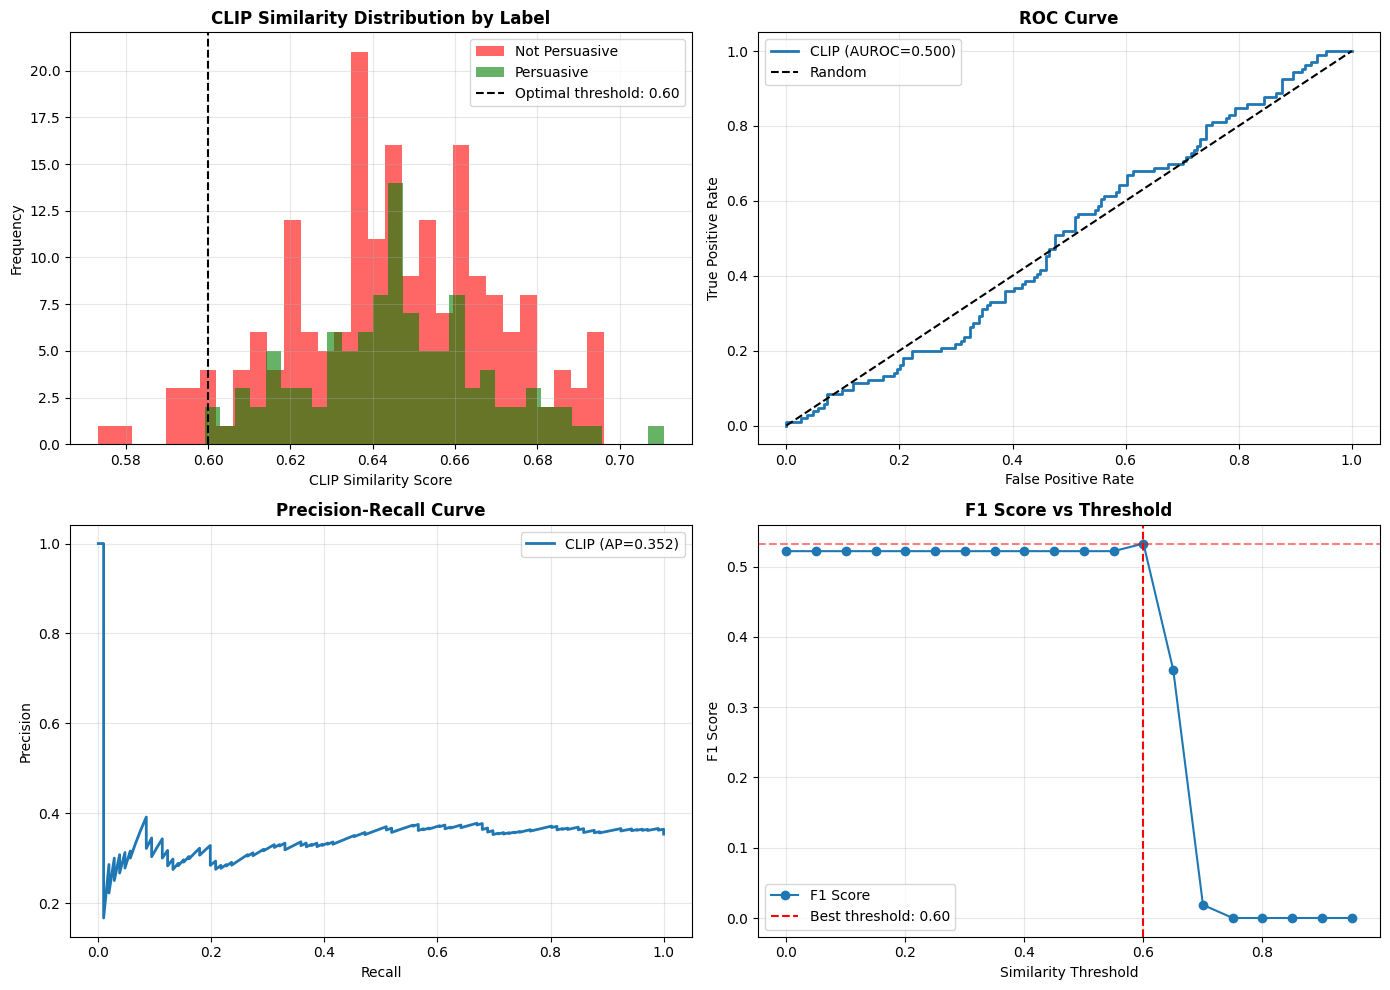

Predictions saved in ../../../experiments/vision/contrastive_persuasiveness/: clip_zeroshot_predictions.csv


In [31]:
# We predict with our optimal threshold
optimal_preds = (similarities >= best_threshold).astype(int)
optimal_acc = accuracy_score(labels, optimal_preds)

print(f"\n CLIP Zero-Shot Performance (binary with threshold={best_threshold:.2f}):")
print(f"  Accuracy: {optimal_acc:.4f}")
print(f"  F1 Score: {best_f1:.4f}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Similarity distribution by label
axes[0, 0].hist(similarities[labels == 0], bins=30, alpha=0.6, label='Not Persuasive', color='red')
axes[0, 0].hist(similarities[labels == 1], bins=30, alpha=0.6, label='Persuasive', color='green')
axes[0, 0].axvline(best_threshold, color='black', linestyle='--', label=f'Optimal threshold: {best_threshold:.2f}')
axes[0, 0].set_xlabel('CLIP Similarity Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('CLIP Similarity Distribution by Label', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# ROC Curve
fpr, tpr, _ = roc_curve(labels, similarities)
axes[0, 1].plot(fpr, tpr, label=f'CLIP (AUROC={auroc:.3f})', linewidth=2)
axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(labels, similarities)
axes[1, 0].plot(recall, precision, linewidth=2, label=f'CLIP (AP={ap:.3f})')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision-Recall Curve', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# F1 vs Threshold
threshold_df = pd.DataFrame(threshold_results)
axes[1, 1].plot(threshold_df['threshold'], threshold_df['f1'], marker='o', label='F1 Score')
axes[1, 1].axvline(best_threshold, color='red', linestyle='--', label=f'Best threshold: {best_threshold:.2f}')
axes[1, 1].axhline(best_f1, color='red', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Similarity Threshold')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].set_title('F1 Score vs Threshold', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'clip_zeroshot_evaluation.png'), dpi=300, bbox_inches='tight')
plt.show()

# Save results
results_df = pd.DataFrame({'tweet_id': tweet_ids,'text': texts,'similarity_score': similarities,'persuasiveness_true': labels,'persuasiveness_pred': optimal_preds})
results_df.to_csv(os.path.join(OUTPUT_DIR, 'clip_zeroshot_predictions.csv'), index=False)
print(f"Predictions saved in {OUTPUT_DIR}: clip_zeroshot_predictions.csv")


### CLIP Fine-Tuned with Contrastive Loss

General idea: We pull together embeddings of persuasive (image, text), and we push apart embeddings of non-persuasive pairs. For persuasive pairs: maximize cosine similarity, for non-persuasive pairs: minimize cosine similarity. This should improve the previous CLIP Score because it's align to our specific domain (Gun Control / Abortion)

In [37]:
class CLIPPersuasivenessModel(nn.Module):

    def __init__(
        self,
        clip_model_name: str = "openai/clip-vit-base-patch32",
        freeze_encoders: bool = False,
        use_mlp_head: bool = True):
        
        super().__init__()
        
        # Load CLIP
        self.clip = CLIPModel.from_pretrained(clip_model_name)
        
        # Optionally freeze encoders
        #Comentario, reentrenar todo?
        if freeze_encoders:
            for param in self.clip.vision_model.parameters():
                param.requires_grad = False
            for param in self.clip.text_model.parameters():
                param.requires_grad = False
            print("CLIP encoders frozen")
        
        self.use_mlp_head = use_mlp_head
        
        # Optional: Add MLP head on top of similarity
        if use_mlp_head:
            self.head = nn.Sequential(
                nn.Linear(512 + 512 + 1, 256),  # concat(img_emb, txt_emb, similarity)
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(256, 1),
                nn.Sigmoid())
        
        print(f"    CLIP Persuasiveness Model initialized")
        print(f"     - Freeze encoders: {freeze_encoders}")
        print(f"     - Use MLP head: {use_mlp_head}")
    
    def forward(self, pixel_values, input_ids, attention_mask):

        # images embeddings
        vision_outputs = self.clip.vision_model(pixel_values=pixel_values)
        image_embeds = vision_outputs.pooler_output
        
        # text embeddings 
        text_outputs = self.clip.text_model(input_ids=input_ids,attention_mask=attention_mask)
        text_embeds = text_outputs.pooler_output
        
        # Project
        image_embeds = self.clip.visual_projection(image_embeds)
        text_embeds = self.clip.text_projection(text_embeds)
        
        # Normalize
        image_embeds = F.normalize(image_embeds, p=2, dim=1)
        text_embeds = F.normalize(text_embeds, p=2, dim=1)
        
        # Cosine similarity
        similarity = (image_embeds * text_embeds).sum(dim=1)
        similarity_01 = (similarity + 1) / 2 
        
        # If we use MLP head, we concatenate features
        if self.use_mlp_head:
            features = torch.cat([image_embeds,text_embeds,similarity_01.unsqueeze(1)], dim=1)
            persuasiveness_score = self.head(features).squeeze(1)
            return similarity_01, persuasiveness_score
        else:
            return similarity_01, similarity_01

def contrastive_persuasiveness_loss(similarity, labels, temperature=0.07):

    # For persuasive pairs: maximize similarity (minimize negative similarity)
    # For non-persuasive pairs: minimize similarity (maximize negative similarity)
    
    # Convert similarity to logits
    logits = similarity / temperature

    #Where we use logits?
    
    # BCE-like loss
    # If label=1 (persuasive): want similarity → 1
    # If label=0 (not persuasive): want similarity → 0
    
    # Convert similarity from [-1, 1] to [0, 1]
    similarity_01 = (similarity + 1) / 2
    
    # Binary cross entropy
    loss = F.binary_cross_entropy(similarity_01, labels)
    
    return loss

def train_clip_persuasiveness(model,train_loader,dev_loader,num_epochs=10,learning_rate=5e-6,weight_decay=1e-4,
    device=device):

    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
    
    # Scheduler
    num_training_steps = len(train_loader) * num_epochs
    num_warmup_steps = int(num_training_steps * WARMUP_RATIO)
    scheduler = get_cosine_schedule_with_warmup(optimizer,num_warmup_steps=num_warmup_steps,num_training_steps=num_training_steps)
    
    best_auroc = 0
    best_model_state = None
    history = {'train_loss': [],
                'dev_auroc': [],
                  'dev_ap': []}
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        
        # Training
        model.train()
        train_loss = 0
        
        pbar = tqdm(train_loader, desc="Training")
        for batch in pbar:
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['persuasiveness'].to(device)
            
            # Forward
            similarity, pred_score = model(pixel_values, input_ids, attention_mask)
            
            # Loss
            loss = F.binary_cross_entropy(pred_score, labels)

            #sim_loss = F.binary_cross_entropy(similarity_01, labels)
            #mlp_loss = F.binary_cross_entropy(pred_score, labels)
            #loss = sim_loss + mlp_loss

            
            # Backward
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item() * pixel_values.size(0)
            pbar.set_postfix({'loss': f"{loss.item():.4f}"})
        
        train_loss /= len(train_loader.dataset)
        
        # Validation
        model.eval()
        all_scores = []
        all_labels = []
        
        with torch.no_grad():
            for batch in tqdm(dev_loader, desc="Validation", leave=False):
                pixel_values = batch['pixel_values'].to(device)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['persuasiveness']
                
                _, pred_score = model(pixel_values, input_ids, attention_mask)
                
                all_scores.extend(pred_score.cpu().numpy())
                all_labels.extend(labels.numpy())
        
        all_scores = np.array(all_scores)
        all_labels = np.array(all_labels)
        
        auroc = roc_auc_score(all_labels, all_scores)
        ap = average_precision_score(all_labels, all_scores)
        
        history['train_loss'].append(train_loss)
        history['dev_auroc'].append(auroc)
        history['dev_ap'].append(ap)
        
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Dev AUROC: {auroc:.4f} | Dev AP: {ap:.4f}")
        
        if auroc > best_auroc:
            best_auroc = auroc
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            print(f" New best AUROC: {best_auroc:.4f}")
    
    # Load best model
    model.load_state_dict(best_model_state)
    model = model.to(device)
    
    print(f"\n Training complete! Best Dev AUROC: {best_auroc:.4f}")
    return model, history


In [38]:

# Create datasets

#Train
clip_train_dataset = ImageTextDatasetCLIP(df_train, IMG_PATH, clip_processor)
clip_train_loader = DataLoader(clip_train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True,
                              collate_fn=custom_collate_fn_clip)

#TDev
clip_dev_dataset = ImageTextDatasetCLIP(df_dev, IMG_PATH, clip_processor)
clip_dev_loader = DataLoader(clip_dev_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True,
                              collate_fn=custom_collate_fn_clip)

# Initialize model
clip_finetuned_model = CLIPPersuasivenessModel(clip_model_name=CLIP,freeze_encoders=False)

# Train
clip_finetuned_model, clip_history = train_clip_persuasiveness(
    clip_finetuned_model,
    clip_train_loader,
    clip_dev_loader,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    device=device)

# Evaluate on test set
print("\n Evaluating CLIP Fine-tuned on TEST set...")
clip_finetuned_model.eval()
finetuned_scores = []
finetuned_labels = []

with torch.no_grad():
    for batch in tqdm(clip_test_loader, desc="Testing"):
        pixel_values = batch['pixel_values'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        _, pred_score = clip_finetuned_model(pixel_values, input_ids, attention_mask)
        
        finetuned_scores.extend(pred_score.cpu().numpy())
        finetuned_labels.extend(batch['persuasiveness'].numpy())

finetuned_scores = np.array(finetuned_scores)
finetuned_labels = np.array(finetuned_labels)

# Metrics
finetuned_auroc = roc_auc_score(finetuned_labels, finetuned_scores)
finetuned_ap = average_precision_score(finetuned_labels, finetuned_scores)

print("\n\n\nCLIP FINE-TUNED TEST RESULTS")
print(f"AUROC: {finetuned_auroc:.4f}")
print(f"Average Precision: {finetuned_ap:.4f}")
print(f"\nComparison with Zero-Shot:")
print(f"  Zero-Shot AUROC: {auroc:.4f}")
print(f"  Fine-tuned AUROC: {finetuned_auroc:.4f}")
print(f"  Improvement: {(finetuned_auroc - auroc):.4f} ({((finetuned_auroc/auroc - 1)*100):.1f}%)")

# Save model
torch.save(clip_finetuned_model.state_dict(), 
           os.path.join(OUTPUT_DIR, 'clip_finetuned_persuasiveness.pth'))
print(f"model saved in {OUTPUT_DIR}: clip_finetuned_persuasiveness.pth")


    CLIP Persuasiveness Model initialized
     - Freeze encoders: False
     - Use MLP head: True

Epoch 1/10


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.6622
Dev AUROC: 0.6811 | Dev AP: 0.4468
 New best AUROC: 0.6811

Epoch 2/10


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11a7ced990>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11a7ced990>Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__

Traceback (most recent call last):
      File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
self._shutdown_workers()
    self._shutdown_workers()  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

      File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():if w.is_alive():

  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  F

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.6302
Dev AUROC: 0.7210 | Dev AP: 0.5249
 New best AUROC: 0.7210

Epoch 3/10


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11a7ced990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11a7ced990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimo

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.6187
Dev AUROC: 0.7382 | Dev AP: 0.5729
 New best AUROC: 0.7382

Epoch 4/10


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11a7ced990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11a7ced990>self._shutdown_workers()

Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        if w.is_alive():
self._shutdown_workers()  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

      File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
assert self._parent_

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11a7ced990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11a7ced990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimo

Train Loss: 0.5956
Dev AUROC: 0.7366 | Dev AP: 0.5482

Epoch 5/10


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11a7ced990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f11a7ced990>  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

    Traceback (most recent call last):
if w.is_alive():  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__

      File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()    
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
assert self._parent_

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11a7ced990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11a7ced990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimo

Train Loss: 0.5669
Dev AUROC: 0.7505 | Dev AP: 0.5938
 New best AUROC: 0.7505

Epoch 6/10


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11a7ced990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11a7ced990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimo

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11a7ced990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11a7ced990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimo

Train Loss: 0.5421
Dev AUROC: 0.7474 | Dev AP: 0.5663

Epoch 7/10


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11a7ced990>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f11a7ced990>
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call last):
      File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
self._shutdown_workers()    
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

      File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.5188
Dev AUROC: 0.7306 | Dev AP: 0.5543

Epoch 8/10


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11a7ced990><function _MultiProcessingDataLoaderIter.__del__ at 0x7f11a7ced990>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        self._shutdown_workers()
self._shutdown_workers()  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

      File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
if w.is_alive():    
if w.is_alive():  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

   

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.5065
Dev AUROC: 0.7509 | Dev AP: 0.5876
 New best AUROC: 0.7509

Epoch 9/10


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11a7ced990>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f11a7ced990>Traceback (most recent call last):

  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
        if w.is_alive():
if w.is_alive():  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

   

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.4996
Dev AUROC: 0.7515 | Dev AP: 0.5920
 New best AUROC: 0.7515

Epoch 10/10


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11a7ced990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11a7ced990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimo

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.4964
Dev AUROC: 0.7525 | Dev AP: 0.5941
 New best AUROC: 0.7525

 Training complete! Best Dev AUROC: 0.7525

 Evaluating CLIP Fine-tuned on TEST set...


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11a7ced990>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f11a7ced990>Traceback (most recent call last):

  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call last):
      File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

      File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
if w.is_alive():    
if w.is_alive():  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

   




CLIP FINE-TUNED TEST RESULTS
AUROC: 0.6943
Average Precision: 0.5641

Comparison with Zero-Shot:
  Zero-Shot AUROC: 0.4999
  Fine-tuned AUROC: 0.6943
  Improvement: 0.1944 (38.9%)
model saved in ../../../experiments/vision/contrastive_persuasiveness/: clip_finetuned_persuasiveness.pth


### BLIP-2 Fine-Tuned

General idea: We'll fine-tune BLIP-2 for persuasiveness scoring, same as CLIP but BLIP it's more recent than CLIP (2023), uses Q-former ( with cross-Attention, so both embeddings learn from each other and from themselves) to bridge vision and language, it's supposely better at complex visual reasoning and since we have memes could perform better.

In [63]:
blip2_processor = Blip2Processor.from_pretrained("Salesforce/blip2-flan-t5-xl")
blip2_model = Blip2QFormerModel.from_pretrained("Salesforce/blip2-flan-t5-xl")

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

AttributeError: 'Blip2Config' object has no attribute 'hidden_size'

In [57]:
#Create our dataset for BLIP
class BLIP2Dataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, image_dir: str, processor, text_column="caption", label_column="label"):
        """
        dataframe: df con columns [image_path, caption, label]
        processor: Blip2Processor
        image_root: carpeta donde están las imágenes
        """

        self.df = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.processor = processor
        self.text_col = text_column
        self.label_col = label_column

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load image
        img_path = os.path.join(self.image_dir, f"{row['tweet_id']}.jpg")
        try:
            image = Image.open(img_path).convert("RGB")
        except:
            image = Image.new("RGB", (224, 224), color=(0, 0, 0))

        # Get text
        text = str(row['tweet_text'])
        
        # Get labels
        persuasiveness = torch.tensor(row["persuasiveness_label"], dtype=torch.float32)

        
        return {
            "image": image,
            "text": text,
            "persuasiveness": persuasiveness,
            "tweet_id": row["tweet_id"],
        }



def blip2_collate_fn(batch, processor):
    
    images = [item["image"] for item in batch]
    texts = [item["text"] for item in batch]
    persuasiveness = torch.stack([item["persuasiveness"] for item in batch])
    tweet_ids = [item["tweet_id"] for item in batch]
    
    # Processed together (Very important for BLIP Architecture)
    encoded = processor(
        images=images,
        text=texts,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    pixel_values = encoded["pixel_values"]
    input_ids = encoded.get("input_ids", None)
    attention_mask = encoded.get("attention_mask", None)

    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "persuasiveness": persuasiveness,
        "tweet_id": tweet_ids,
    }

In [58]:
# we generate our Blip-2 Model  Architecture
class BLIP2PersuasivenessModel(nn.Module):
    
    def __init__(self, blip2_model):
        super().__init__()
        self.blip2 = blip2_model
        
        # Freeze most of BLIP-2 (it's large)
        for param in self.blip2.parameters():
            param.requires_grad = False
        
        # Small trainable head
        hidden_dim = self.blip2.config.qformer_config.hidden_size
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid())
        print("Only training Q-Former and classification head")
    
    def forward(self, pixel_values, input_ids=None, attention_mask=None):
        # Get Q-Former outputs
        outputs = self.blip2(
            pixel_values=pixel_values,
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True)
        
        # Use Q-Former outputs
        qformer_outputs = outputs.qformer_outputs
        pooled = qformer_outputs.pooler_output  # [batch, hidden_dim]
        
        # Predict
        score = self.head(pooled).squeeze(1)
        return score

In [60]:
#We train BLIP-2 for persuasiveness prediction

# Create BLIP-2 datasets
blip2_train_dataset = BLIP2Dataset(df_train,IMG_PATH,blip2_processor)
blip2_dev_dataset = BLIP2Dataset(df_dev,IMG_PATH,blip2_processor)
blip2_test_dataset = BLIP2Dataset(df_test,IMG_PATH,blip2_processor)

blip2_train_loader = DataLoader(blip2_train_dataset,batch_size=BATCH_SIZE,shuffle=True,
                          collate_fn=lambda batch: blip2_collate_fn(batch, blip2_processor))
blip2_dev_loader = DataLoader(blip2_dev_dataset,batch_size=BATCH_SIZE,shuffle=True,
                          collate_fn=lambda batch: blip2_collate_fn(batch, blip2_processor))
blip2_test_loader = DataLoader(blip2_test_dataset,batch_size=BATCH_SIZE,shuffle=True,
                          collate_fn=lambda batch: blip2_collate_fn(batch, blip2_processor))

# Initialize
blip2_pers_model = BLIP2PersuasivenessModel(blip2_model)

# Train 
blip2_pers_model = blip2_pers_model.to(device)
optimizer = torch.optim.AdamW(blip2_pers_model.head.parameters(), lr=1e-4)

best_blip2_auroc = 0

for epoch in range(5):
    print(f"\nEpoch {epoch+1}/5")
    
    blip2_pers_model.train()
    for batch in tqdm(blip2_train_loader, desc="Training"):

        pixel_values = batch['pixel_values'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['persuasiveness'].to(device)

        pred = blip2_pers_model(
            pixel_values=pixel_values,
            input_ids=input_ids,
            attention_mask=attention_mask)

        loss = F.binary_cross_entropy(pred, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Validate
    blip2_pers_model.eval()
    blip2_dev_scores = []
    blip2_dev_labels = []
    
    with torch.no_grad():
        for batch in tqdm(blip2_dev_loader, desc="Validation", leave=False):

            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            pred = blip2_pers_model(
                pixel_values=pixel_values,
                input_ids=input_ids,
                attention_mask=attention_mask)
            
            blip2_dev_scores.extend(pred.cpu().numpy())
            blip2_dev_labels.extend(batch['persuasiveness'].numpy())

    
    dev_auroc = roc_auc_score(blip2_dev_labels, blip2_dev_scores)
    print(f"Dev AUROC: {dev_auroc:.4f}")
    
    if dev_auroc > best_blip2_auroc:
        best_blip2_auroc = dev_auroc
        torch.save(blip2_pers_model.state_dict(), 
                   os.path.join(OUTPUT_DIR, 'blip2_persuasiveness.pth'))


Only training Q-Former and classification head

Epoch 1/5


Training:   0%|          | 0/114 [00:00<?, ?it/s]

ValueError: You have to specify either decoder_input_ids or decoder_inputs_embeds

In [ ]:
# We test BLIP-2 model

blip2_pers_model.eval()
blip2_test_scores = []
blip2_test_labels = []

with torch.no_grad():
    for batch in tqdm(blip2_test_loader, desc="Testing"):
        pixel_values = batch['pixel_values'].to(device)
        pred = blip2_pers_model(pixel_values)
        
        blip2_test_scores.extend(pred.cpu().numpy())
        blip2_test_labels.extend(batch['persuasiveness'].numpy())

blip2_test_scores = np.array(blip2_test_scores)
blip2_test_labels = np.array(blip2_test_labels)

blip2_auroc = roc_auc_score(blip2_test_labels, blip2_test_scores)
blip2_ap = average_precision_score(blip2_test_labels, blip2_test_scores)

print("\n\n\n BLIP-2 TEST RESULTS")
print(f"AUROC: {blip2_auroc:.4f}")
print(f"Average Precision: {blip2_ap:.4f}")

In [ ]:
# Final Comparision between models


comparison = pd.DataFrame({
    'Model': ['CLIP Zero-Shot', 'CLIP Fine-tuned', 'BLIP-2 Fine-tuned'],
    'AUROC': [auroc, finetuned_auroc, blip2_auroc],
    'Average Precision': [ap, finetuned_ap, blip2_ap],
    'Training Time': ['0 (no training)', '~30 min', '~45 min'],
    'Inference Speed': ['Fast', 'Fast', 'Slow']})


# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# AUROC comparison
axes[0].bar(comparison['Model'], comparison['AUROC'], color = ["blue", "orange", "green"])
axes[0].set_title('AUROC Comparison', fontweight='bold', fontsize=14)
axes[0].set_ylabel('AUROC')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)
for i, row in comparison.iterrows():
    axes[0].text(i, row['AUROC'] + 0.02, f"{row['AUROC']:.3f}", ha='center', fontweight='bold')

# AP comparison
axes[1].bar(comparison['Model'], comparison['Average Precision'], color =["blue", "orange", "green"])
axes[1].set_title('Average Precision Comparison', fontweight='bold', fontsize=14)
axes[1].set_ylabel('Average Precision')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)
for i, row in comparison.iterrows():
    axes[1].text(i, row['Average Precision'] + 0.02, f"{row['Average Precision']:.3f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'final_comparison.png'), bbox_inches='tight')
plt.show()

In [ ]:

#  Concluson: Best Model
best_model = comparison.loc[comparison['AUROC'].idxmax(), 'Model']
best_auroc = comparison['AUROC'].max()

print(f"\n Best Model: {best_model} with AUROC={best_auroc:.4f}")

KEY FINDINGS:
1. CLIP zero-shot provides decent baseline (AUROC={auroc:.3f})
2. Fine-tuning improves performance by {((finetuned_auroc/auroc - 1)*100):.1f}%
3. {best_model} is recommended for multimodal fusion
